In [3]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

import sys
!{sys.executable} -m pip install seaborn --quiet

import seaborn as sns

import sys
!{sys.executable} -m pip install transformers

# VADER MODEL 

In [8]:
y_train_tensor = torch.tensor(y_train_seq, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_seq, dtype=torch.float32)

✅ Dataset Shape: (14457, 37)
🧱 Columns: ['minute', 'open', 'high', 'low', 'close', 'volume', 'vol_mean_1h', 'rolling_max_24h', 'tier1', 'tier2', 'tier3', 'drawdown_24h', 'log_ret', 'volatility_5m', 'volatility_15m', 'volatility_60m', 'mom_3m', 'mom_10m', 'mom_30m', 'vol_z_10m', 'vol_z_60m', 'label_t1_L5_H15', 'label_t2_L10_H30', 'label_t3_L60_H240', 'label_multiclass', 'AllCryptoBets_vader', 'Bitcoin_vader', 'CryptoCurrency_vader', 'CryptoMars_vader', 'CryptoMoon_vader', 'CryptoMoonCoins_vader', 'CryptoMoonShots_vader', 'CryptocurrencyICO_vader', 'cryptostreetbets_vader', 'noncensored_bitcoin_vader', 'vader_aggregate', 'flash_crash']
🔍 Flash Crash Class Distribution:
0    0.994536
1    0.005464
Name: flash_crash, dtype: float64


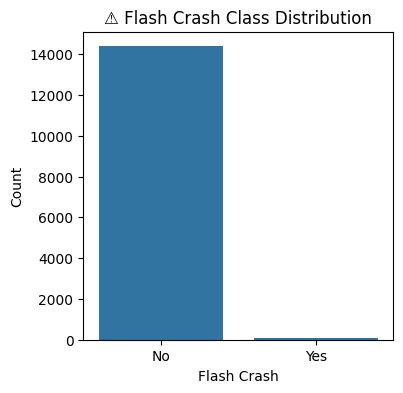

/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128338 (\N{CLOCK FACE THREE OCLOCK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


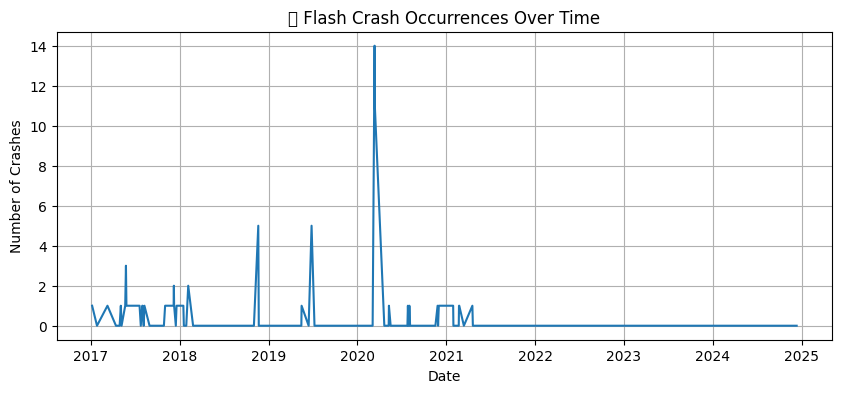

/tmp/ipykernel_4086/2502754563.py:42: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


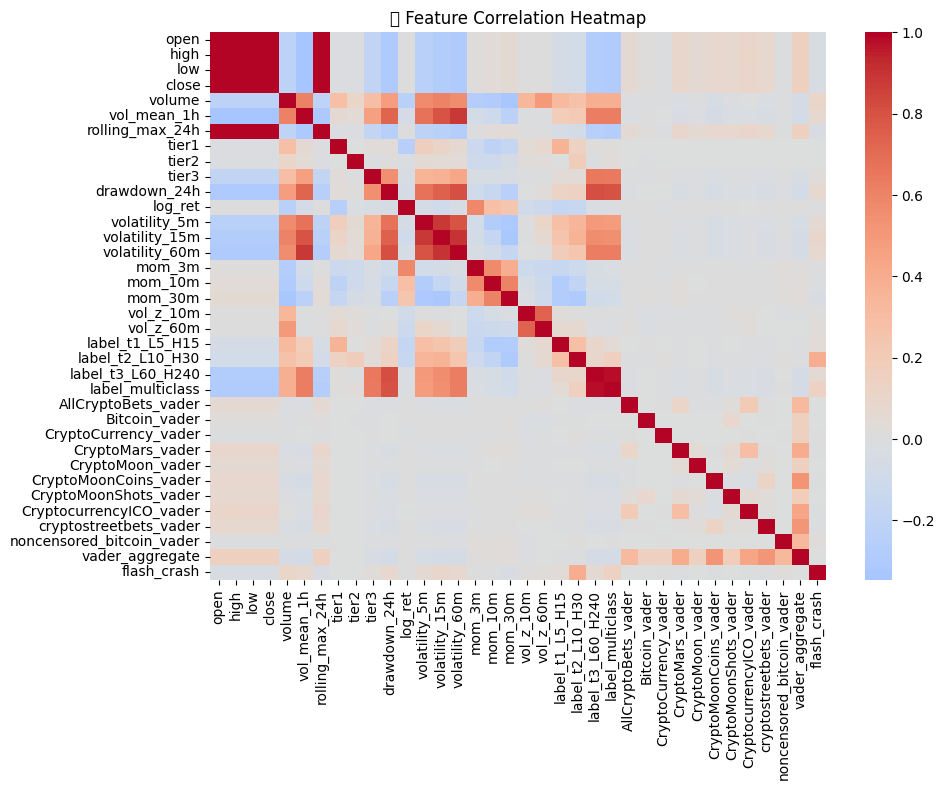

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset (change file as needed)
df = pd.read_csv('train_vader.csv', parse_dates=['minute'])

# Basic info
print("✅ Dataset Shape:", df.shape)
print("🧱 Columns:", df.columns.tolist())
print("🔍 Flash Crash Class Distribution:")
print(df['flash_crash'].value_counts(normalize=True))

# Plot class balance
plt.figure(figsize=(4, 4))
sns.countplot(x='flash_crash', data=df)
plt.title('⚠️ Flash Crash Class Distribution')
plt.xlabel('Flash Crash')
plt.ylabel('Count')
plt.xticks([0, 1], ['No', 'Yes'])
plt.show()

# Time series volume of flash crash
df['minute'] = pd.to_datetime(df['minute'])
crash_counts = df.groupby(df['minute'].dt.date)['flash_crash'].sum()

plt.figure(figsize=(10, 4))
crash_counts.plot()
plt.title('🕒 Flash Crash Occurrences Over Time')
plt.ylabel('Number of Crashes')
plt.xlabel('Date')
plt.grid(True)
plt.show()

# Correlation heatmap of features (sample if too large)
sample_df = df.sample(n=min(5000, len(df)), random_state=42)
corr = sample_df.drop(columns=['minute']).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title('📈 Feature Correlation Heatmap')
plt.tight_layout()
plt.show()


Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
⛔ Early stopping triggered.
\Final Batched Test Accuracy: 0.7387

 Classification Report:
              precision    recall  f1-score   support

         0.0     0.6676    0.6722    0.6699     22400
         1.0     0.7855    0.7820    0.7838     34392

    accuracy                         0.7387     56792
   macro avg     0.7266    0.7271    0.7268     56792
weighted avg     0.7390    0.7387    0.7389     56792



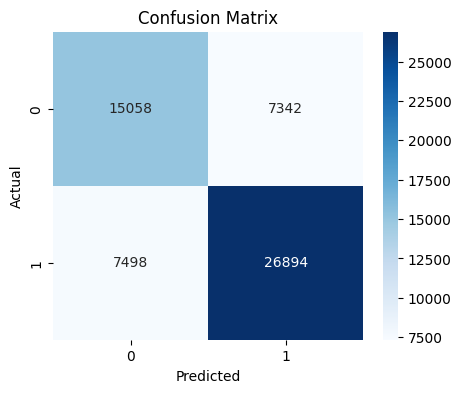

In [23]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ========== STEP 1: Load & Preprocess ==========
train_df = pd.read_csv('train_vader.csv', parse_dates=['minute'])
test_df = pd.read_csv('test_common.csv', parse_dates=['minute'])

cols_to_drop = ['minute', 'label_t1_L5_H15', 'label_t2_L10_H30', 'label_t3_L60_H240']
train_df = train_df.drop(columns=cols_to_drop)
test_df = test_df.drop(columns=cols_to_drop)

X_train = train_df.drop(columns=['flash_crash'])
y_train = train_df['flash_crash'].values.astype(np.float32)

X_test = test_df.drop(columns=['flash_crash'])
y_test = test_df['flash_crash'].values.astype(np.float32)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ========== STEP 2: Create Sequences ==========
def create_sequence_data(X, y, seq_len=60):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len])
    return np.array(X_seq), np.array(y_seq)

seq_len = 60
X_train_seq, y_train_seq = create_sequence_data(X_train_scaled, y_train, seq_len)
X_test_seq, y_test_seq = create_sequence_data(X_test_scaled, y_test, seq_len)

# ========== STEP 3: Torch Tensors + Train Loader ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor = torch.tensor(X_train_seq, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_seq, dtype=torch.float32)

train_loader = DataLoader(
    TensorDataset(X_train_tensor, y_train_tensor),
    batch_size=256,
    shuffle=True
)

# ========== STEP 4: Define LSTM Model (No Sigmoid!) ==========
class BiLSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=160, num_layers=3, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers,
                            batch_first=True, dropout=dropout, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out.view(-1)


input_dim = X_train.shape[1]
model = BiLSTMModel(input_dim).to(device)

# Compute pos_weight
neg = (y_train_seq == 0).sum()
pos = (y_train_seq == 1).sum()
weight = torch.tensor([neg / pos], dtype=torch.float32).to(device)

# ========== STEP 5: Loss and Optimizer ==========
criterion = nn.BCEWithLogitsLoss(pos_weight=weight)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
torch.backends.cudnn.benchmark = True


X_test_tensor = torch.tensor(X_test_seq, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_seq, dtype=torch.float32)

test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=512)


# ========== STEP 6: Train the Model ==========
model.train()
prev_val_loss = float('inf')
for epoch in range(15):
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        logits = model(X_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    # Track validation loss (evaluate on test set each epoch)
    model.eval()
    val_losses = []
    with torch.no_grad():
        val_preds = []
        val_targets = []
        for xb, yb in test_loader:
            xb = xb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb.to(device))
            val_losses.append(loss.item())
            val_preds += torch.sigmoid(logits).cpu().numpy().tolist()
            val_targets += yb.numpy().tolist()

    avg_val_loss = np.mean(val_losses)

    # Early stopping (if needed)
    if epoch > 2 and avg_val_loss > prev_val_loss:
        print("⛔ Early stopping triggered.")
        break
    prev_val_loss = avg_val_loss
    model.train()


    print(f"Epoch {epoch+1}/10")

# ========== STEP 7: Batched Test Evaluation ==========
X_test_tensor = torch.tensor(X_test_seq, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_seq, dtype=torch.float32)

test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=512)

model.eval()
preds = []
true_labels = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        logits = model(xb)
        probs = torch.sigmoid(logits).cpu().numpy()  # Apply sigmoid here!
        preds += probs.tolist()
        true_labels += yb.numpy().tolist()

preds_binary = [1 if p > 0.3 else 0 for p in preds]  # threshold lowered
accuracy = accuracy_score(true_labels, preds_binary)
print(f"\Final Batched Test Accuracy: {accuracy:.4f}")

# ========== STEP 8: Evaluation Metrics ==========
print("\n Classification Report:")
print(classification_report(true_labels, preds_binary, digits=4))

cm = confusion_matrix(true_labels, preds_binary)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

# 📉 RMSE and MAE (using raw probabilities)
rmse = math.sqrt(mean_squared_error(true_labels, preds))
mae = mean_absolute_error(true_labels, preds)

print(f"\n📉 RMSE: {rmse:.4f}")
print(f"📉 MAE: {mae:.4f}")



📉 RMSE: 0.5114
📉 MAE: 0.3599


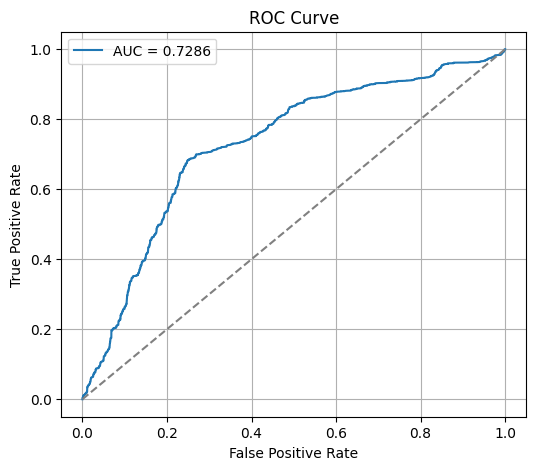

In [21]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# ROC + AUC
fpr, tpr, _ = roc_curve(val_targets, val_preds)
auc_score = roc_auc_score(val_targets, val_preds)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()
